## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:



# Project Title

## Overview

## Business Problem

## Data Understanding

We need to access data to solve our business problem:
- tn.movie_budgets.csv.gz contains
    - `production_budget`, `domestic_gross`, `worldwide_gross`

- im.db contains
    - `movie_basics` table with movie's `primary_name` and `genres`
    - `movie_ratings` table with `averagerating` and `numvotes`
    - `principals` table with `category` of people's roles in the movie (e.g., directors)
    - `persons` table with names of the principals (directors)

- bom.movie_gross.csv.gz contains
    - the `studio` that produced each movie


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# print big numbers in pd.DataFrame (instead of scientific notation)
pd.set_option('display.precision', 12)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set matplotlib title font size
plt.rcParams['axes.titlesize'] = 18

## The Numbers Data
- Contains `production_budget`, `domestic_gross`, and `worldwide_gross` 

In [2]:
# create The Numbers data frame
tn_movie_budgets_df = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
# show it contains movies, both big and small
tn_movie_budgets_df.iloc[[5, 500, 5000]]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
500,1,"Jun 8, 2007",Ocean's Thirteen,"$85,000,000","$117,144,465","$311,744,465"
5000,1,"Dec 1, 2015",Shark Lake,"$2,000,000",$0,$0


### Data Cleaning
- Money columns in The Numbers are formatted as string with special characters (e.g., $425,000,000)

In [3]:
#Helper function to clean the money columns
def convert_money_string(money_series):
    '''
    This function takes a pd.Series with string values representing money (USD) and converts that string to float
    '''
    return money_series.str.replace('$','').str.replace(',','').astype(float)

In [4]:
# Here we clean special characters out of the money strings, convert the strings into floats,
# and then create column of values in millions of dollars
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    tn_movie_budgets_df[col] = convert_money_string(tn_movie_budgets_df[col])
    col_mil = f"{col}_mil"
    tn_movie_budgets_df[col_mil] = tn_movie_budgets_df[col] / 1000000

### Feature Engineering
- We want to focus on profit, which is income minus costs
- We can also calculate return on investment (\\$ profit per \\$cost)

In [5]:
# Here we calculated worldwide_profit in millions for each movie
tn_movie_budgets_df['worldwide_profit_mil'] = tn_movie_budgets_df['worldwide_gross_mil'] - tn_movie_budgets_df['production_budget_mil']
# Here we calculated return on investment for each movie
tn_movie_budgets_df['ROI'] = tn_movie_budgets_df['worldwide_profit_mil'] / tn_movie_budgets_df['production_budget_mil']

## Box Office Mojo Data
- Contains `domestic_gross`, `foreign_gross`, and `studio`
- `foreign_gross` is formatted as string with special characters (e.g., 425,000,000)

In [6]:
# Here we read in the Box Office Mojo data frame
bom_df = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
# once again to show variety of movies in the data frame
bom_df.iloc[[3,300,3000]]

,title,studio,domestic_gross,foreign_gross,year
3,Inception,WB,292600000.00,535700000,2010
300,Saint John of Las Vegas,IVP,103000.00,9100,2010
3000,My Life as a Zucchini,GK,310000.00,NaN,2017


### Data Cleaning

- Clean the money string and convert to float
- Replace null values with 0

In [7]:
# Call convert_money_string on foreign_gross to get floats
for col in ['foreign_gross']:
    bom_df[col] = convert_money_string(bom_df[col])
    col_mil = f"{col}_mil"
    bom_df[col_mil] = bom_df[col] / 1000000

In [8]:
# Here we are infering that missing values actually represent no money made in a given region
bom_df['foreign_gross'].fillna(0, inplace=True)
bom_df['domestic_gross'].fillna(0, inplace=True)
bom_df['foreign_gross_mil'].fillna(0, inplace=True)

### Feature Engineering
- Create domestic gross in millions of dollars
- Create worldwide gross in millions of dollars

In [9]:
bom_df['domestic_gross_mil'] = bom_df['domestic_gross'] / 1000000
bom_df['bom_worldwide_gross_mil'] = bom_df['domestic_gross_mil'] + bom_df['foreign_gross_mil']

## Internet Movie Database (IMDb) SQL database
- This contains tons of info about movies, people, and popularity

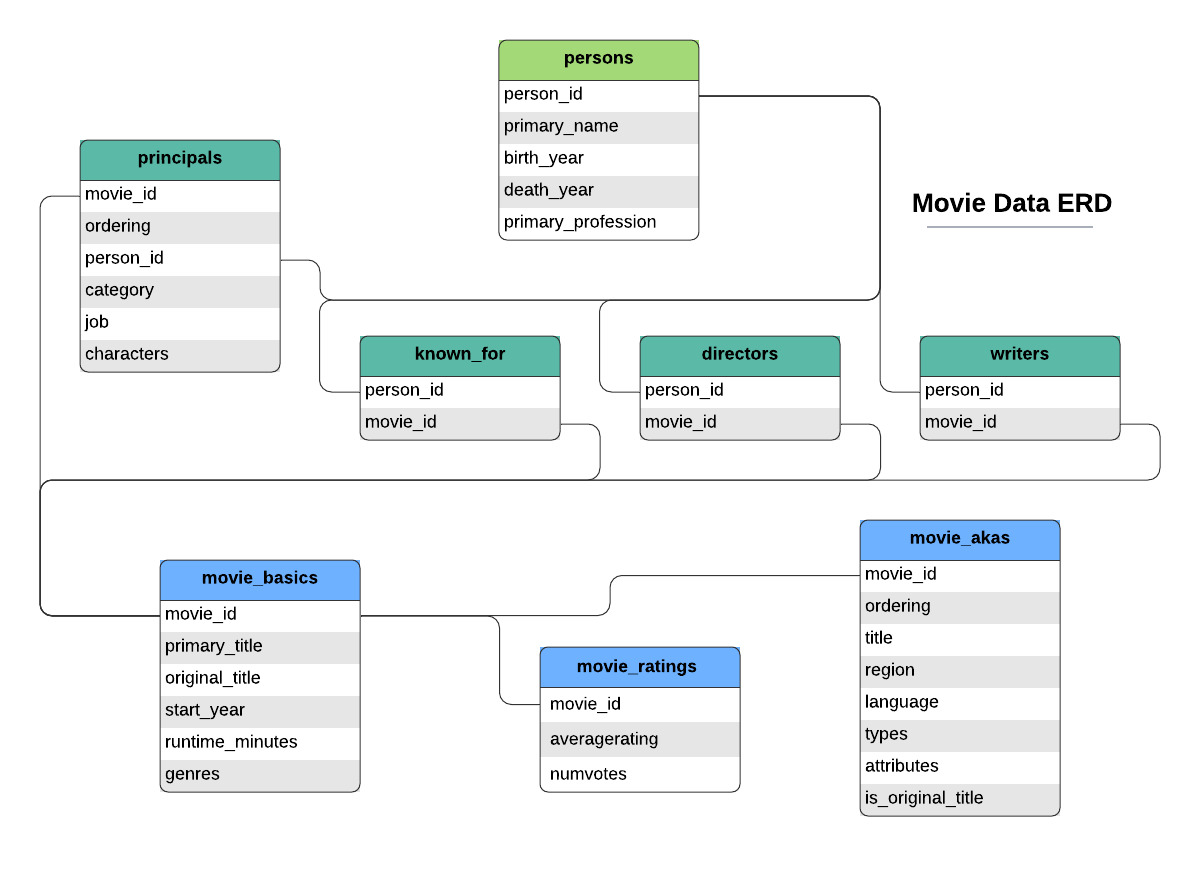



#### Use SQL to get info about `movie_basics` and `movie_ratings`


In [10]:
# Create the connect to im.db database
con = sqlite3.connect('../zippedData/im.db')

#### movie_ratings table
- Contains `averagerating` and `numvotes` are columns of IMDb ratings

In [11]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    movie_ratings
LIMIT 5
""", con)

,movie_id,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


#### movie_basics table
- `primary_title` has duplicate rows with same value
- `genres` is a string that contains multiple genres (separated by commas)
    - We may need to parse this genres string to use it

In [12]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    movie_basics
LIMIT 5
""", con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


#### Use SQL to get info about   `persons` and `principals`

#### persons table
- `primary_name` contains name of the person
- `primary_profession` may be useful, but it is more correct to use `category` from principals table below.

In [13]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    persons
LIMIT 5
""", con)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,None,None,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,None,None,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,None,None,"production_designer,art_department,set_decorator"


#### principals table
- `category` provides the person's role in each specific movie

In [14]:
# What do sample values look like?
pd.read_sql("""
SELECT
    *
FROM
    principals
LIMIT 5
""", con)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


## Data Preparation

#### Let's JOIN im.db `movie_basics`  and `movie_ratings`
- Create `imdb_ratings_df` DataFrame containing the joined names, genres, and ratings for each movie

In [15]:
### Look into who the primary directors are
# Usee LEFT JOIN to keep all movies, even if they are not in the movie_ratings table
imdb_ratings_df = pd.read_sql("""

SELECT
    b.movie_id, b.primary_title, b.original_title, b.start_year, b.runtime_minutes, b.genres,
    r.averagerating, r.numvotes
FROM
    movie_basics as b
    LEFT JOIN movie_ratings as r
        USING(movie_id)

""", con)

#### Let's JOIN im.db `persons`  and `principals`
- Create `imdb_principals_df` DataFrame with all of the info about people / principals
- Keep info about principals separate
    - relationship of `movie_id` to `person_id` is "one-to-many" (i.e., one `person_id` can have multiple roles in each `movie_id`)
    - So, resulting data frame is too bulky for other uses
    - There are multiple directors for some movies, so we may need to figure out how to deal with that to find best directors
- We still want to merge `imdb_ratings_df` **into** `imdb_principals_df` to find movie info for each principal

In [16]:
# Used LEFT JOIN to keep all principals, even if they have no persons info
imdb_principals_df = pd.read_sql("""

SELECT
    *
FROM
    principals
    LEFT JOIN persons
        USING(person_id)

""", con)

In [17]:
# Merge imdb_ratings_df into imdb_principals_df 
# Use left join in order to keep all principals
imdb_principals_df = imdb_principals_df.merge(imdb_ratings_df, on='movie_id', how='left')

## Filter data to those movies that Microsoft Studios might produce
- Assume that Microsoft wants to compete with more productive movie studios
- Assume that Microsoft is not interested in producing "art house" movies that are not popular or profitable
- Assume that Microsoft wants to produce popular movies (with large following and high ratings)

In [18]:
# Find the total worldwide gross for each studio
bom_studio_gross = bom_df.groupby('studio')['bom_worldwide_gross_mil'].sum()

Maybe have a few sentences about how all of the money is made at the top, pointing out the large difference between the median, 75th percentile, and max

In [19]:
# Now, let's focus on top studios (above 90th percentile in gross sales)
gross_sales_90 = np.percentile(bom_studio_gross, 90)

# Test studios in bom_studio_gross df to get list of top studios
filt = bom_studio_gross > gross_sales_90
competing_studios = bom_studio_gross[filt].index

In [20]:
# Use that list of competing studios to filter 
filt = bom_df['studio'].isin(competing_studios)
bom_competing_studios_df = bom_df[filt]

In [21]:
# Show the top studios
# print(f"Number of movies made by top 10% grossing studios: {bom_competing_studios_df.shape[0]}")
# bom_competing_studios_df.groupby('studio')['bom_worldwide_gross_mil'].sum().sort_values(ascending=False)

### Let's get movie and budget info for movies made by the top grossing "competing" studios
- Merge bom_competing_studios_df with tn_movie_budgets_df

In [22]:
# We get multiple rows when we merge tn_movie_budgets_df
# So add 'year' to use as additional key
tn_movie_budgets_df['year'] = tn_movie_budgets_df['release_date'].str[-4:].astype(int)

In [23]:
# Merge to add budgets
competing_studio_budgets_df = bom_competing_studios_df.merge(tn_movie_budgets_df,
                                                             left_on=['title', 'year'],
                                                             right_on=['movie', 'year'],
                                                             how='inner',
                                                             suffixes=('_bom', '_tn')
                                                            )

In [24]:
# Another merge to add ratings
competing_studio_budgets_ratings_df = competing_studio_budgets_df.merge(imdb_ratings_df,
                                                                        left_on=['title', 'year'],
                                                                        right_on=['primary_title', 'start_year'],
                                                                        how='inner')

## Analysis

### How does production budget affect outcomes?
- Consider producing higher budget films: It appears that higher budget films have higher profits and higher popularity

#### Correlations with Production Budget
- worldwide_profit_mil: strong positive correlation
- ROI: no correlation
- averagerating: weak positive correlation
- numvotes: moderate positive correlation

In [25]:
# What are correlations with production budget?
corr_budgets_ratings = competing_studio_budgets_ratings_df[['production_budget_mil', 'worldwide_profit_mil', 
                                                            'ROI', 'averagerating', 'numvotes']].corr()
corr_budgets_ratings.iloc[0]

production_budget_mil    1.00
worldwide_profit_mil     0.64
ROI                     -0.09
averagerating            0.18
numvotes                 0.49
Name: production_budget_mil, dtype: float64

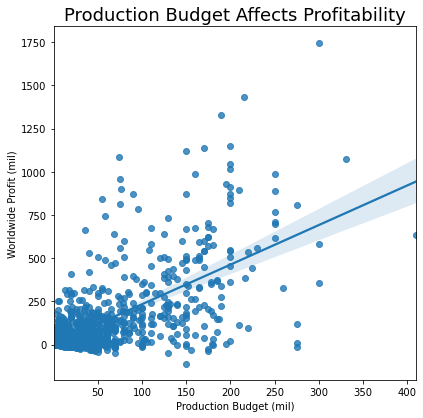

In [26]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.regplot(x='production_budget_mil', y='worldwide_profit_mil', 
                data=competing_studio_budgets_ratings_df, ax=ax)
ax.set_title('Production Budget Affects Profitability')
ax.set_xlabel('Production Budget (mil)')
ax.set_ylabel('Worldwide Profit (mil)')
ax.ticklabel_format(style='plain')
ax.grid(b=False);

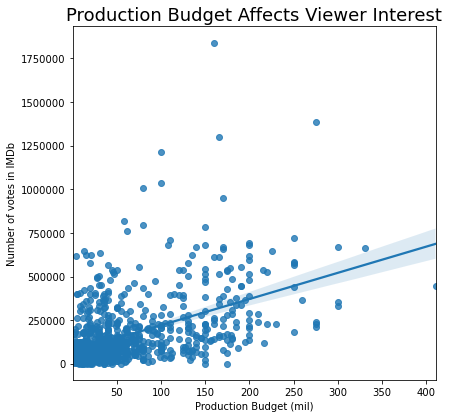

In [27]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.regplot(x='production_budget_mil', y='numvotes', 
                data=competing_studio_budgets_ratings_df, ax=ax)
ax.set_title('Production Budget Affects Viewer Interest')
ax.set_xlabel('Production Budget (mil)')
ax.set_ylabel('Number of votes in IMDb')
ax.ticklabel_format(style='plain')
ax.grid(b=False);

## How does movie genre affect outcomes?
- ROI is highest for Documentary, Horror, Mystery, and Thriller
- Interest (numratings, popularity) is highest for Western, Sci-Fi, Adventure, Action
- Average worldwide profit is highest for Animation, Sci-Fi, Adventure, Action

In [28]:
set_of_genres = set()
for movie_row in competing_studio_budgets_ratings_df['genres'].dropna():
    set_of_genres.update(movie_row.split(','))

list_of_genres = list(set_of_genres)

Here I am creating a new data frame that will contain rows for every genre. This way we can run `.groupby('genre')` to get summarizing statistics for each genre.

In [29]:
tmp_df_columns = list(competing_studio_budgets_ratings_df.columns)
tmp_df_columns.append('genre')
tmp_df = pd.DataFrame(columns=tmp_df_columns)


for genre in list_of_genres:
    filt = competing_studio_budgets_ratings_df['genres'].str.contains(genre, na=False)
    filt_df = competing_studio_budgets_ratings_df[filt]
    filt_df['genre'] = genre
    tmp_df = pd.concat([tmp_df, filt_df])
    
long_competing_studio_budgets_ratings_df = tmp_df

<ipython-input-29-72870965b343>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['genre'] = genre


In [30]:
# Now that we have each genre dataframe stacked on top of each other, we can use .groupby to get mean() for each genre
competing_studio_budgets_ratings_by_genre_df = long_competing_studio_budgets_ratings_df.groupby('genre')[['production_budget_mil', 'worldwide_profit_mil', 'ROI', 'averagerating', 'numvotes']].mean()

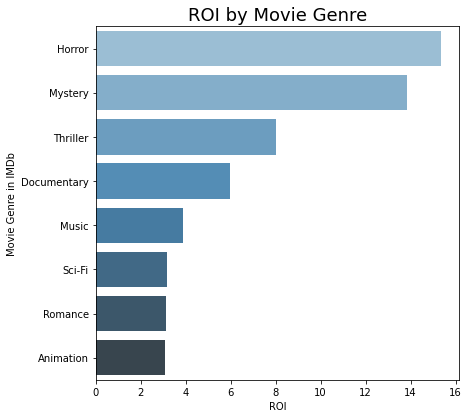

In [31]:
tmp = competing_studio_budgets_ratings_by_genre_df.sort_values('ROI', ascending=False)['ROI'].head(8)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.barplot(y=tmp.index, 
            x=tmp.values,
            palette="Blues_d")
ax.set_title('ROI by Movie Genre')
ax.set_xlabel('ROI')
ax.set_ylabel('Movie Genre in IMDb');

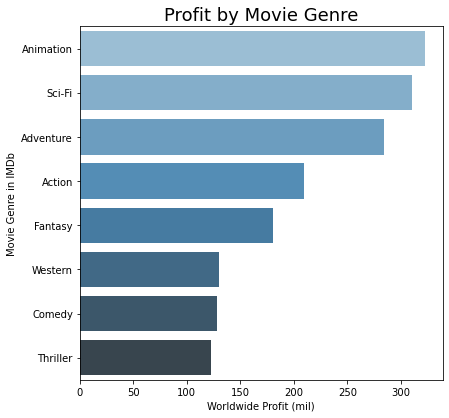

In [32]:
tmp = competing_studio_budgets_ratings_by_genre_df.sort_values('worldwide_profit_mil', ascending=False)['worldwide_profit_mil'].head(8)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.barplot(y=tmp.index, 
            x=tmp.values,
            palette="Blues_d")
ax.set_title('Profit by Movie Genre')
ax.set_xlabel('Worldwide Profit (mil)')
ax.set_ylabel('Movie Genre in IMDb');

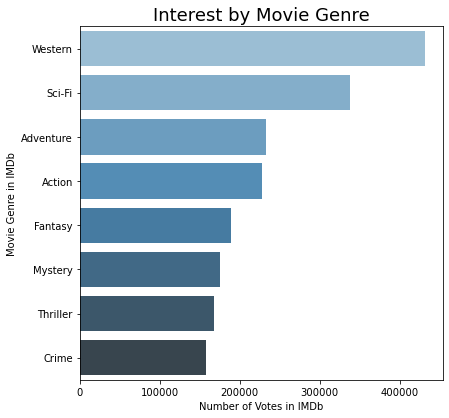

In [33]:
tmp = competing_studio_budgets_ratings_by_genre_df.sort_values('numvotes', ascending=False)['numvotes'].head(8)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.barplot(y=tmp.index, 
            x=tmp.values,
            palette="Blues_d")
ax.set_title('Interest by Movie Genre')
ax.set_xlabel('Number of Votes in IMDb')
ax.set_ylabel('Movie Genre in IMDb');

## How do movie directors affect outcomes?


In [34]:
# Let's make an empty set to save the best directors (we'll cast to list later)
director_set = set()

In [35]:
# created top 50 directors measured by worldwide profit
top_50_worldwide_profit_df = competing_studio_budgets_ratings_df.sort_values('worldwide_profit_mil', ascending=False).head(50)
# created top 50 directors measured by return on investment
top_50_ROI_df = competing_studio_budgets_ratings_df.sort_values('ROI', ascending=False).head(50)
# created top 50 directors measured by number of IMDb votes
top_50_votes_df = competing_studio_budgets_ratings_df.sort_values('numvotes', ascending=False).head(50)

In [36]:
principals_top_50_worldwide_profit_df = imdb_principals_df.merge(top_50_worldwide_profit_df, on='movie_id', how='inner')

In [37]:
filt = (principals_top_50_worldwide_profit_df['category'] == 'director')
sorted_df = principals_top_50_worldwide_profit_df[filt].sort_values('worldwide_profit_mil', ascending=False)
director_set.update(sorted_df.head(10)['primary_name'])
sorted_df.head(10)[['primary_name', 'primary_title_x', 'worldwide_profit_mil']]

,primary_name,primary_title_x,worldwide_profit_mil
436,Joe Russo,Avengers: Infinity War,1748.13
435,Anthony Russo,Avengers: Infinity War,1748.13
35,Colin Trevorrow,Jurassic World,1433.85
455,James Wan,Furious 7,1328.72
85,Ryan Coogler,Black Panther,1148.26
465,J.A. Bayona,Jurassic World: Fallen Kingdom,1135.77
175,Chris Buck,Frozen,1122.47
176,Jennifer Lee,Frozen,1122.47
245,Kyle Balda,Minions,1086.34
375,Joss Whedon,Avengers: Age of Ultron,1072.41


In [38]:
principals_top_50_ROI_df = imdb_principals_df.merge(top_50_ROI_df, on='movie_id', how='inner')
filt = principals_top_50_ROI_df['category'] == 'director'
sorted_df = principals_top_50_ROI_df[filt].sort_values('ROI', ascending=False)
director_set.update(sorted_df.head(10)['primary_name'])
sorted_df.head(10)[['primary_name', 'primary_title_x', 'ROI']]

,primary_name,primary_title_x,ROI
234,Chris Lofing,The Gallows,415.56
233,Travis Cluff,The Gallows,415.56
5,William Brent Bell,The Devil Inside,100.76
203,Tod Williams,Paranormal Activity 2,58.17
413,Jordan Peele,Get Out,50.07
114,Bradley Parker,Chernobyl Diaries,41.41
36,Ariel Schulman,Paranormal Activity 3,40.41
35,Henry Joost,Paranormal Activity 3,40.41
283,John R. Leonetti,Annabelle,38.52
253,Daniel Stamm,The Last Exorcism,37.98


In [39]:
principals_top_50_votes_df = imdb_principals_df.merge(top_50_votes_df, on='movie_id', how='inner')
filt = principals_top_50_votes_df['category'] == 'director'
sorted_df = principals_top_50_votes_df[filt].sort_values('numvotes_y', ascending=False)
director_set.update(sorted_df.head(10)['primary_name'])
sorted_df.head(10)[['primary_name', 'primary_title_x', 'numvotes_y']]

,primary_name,primary_title_x,numvotes_y
315,Christopher Nolan,Inception,1841066.00
345,Christopher Nolan,The Dark Knight Rises,1387769.00
415,Christopher Nolan,Interstellar,1299334.00
185,Quentin Tarantino,Django Unchained,1211405.00
235,Martin Scorsese,The Wolf of Wall Street,1035358.00
155,Martin Scorsese,Shutter Island,1005960.00
15,James Gunn,Guardians of the Galaxy,948394.00
205,Tim Miller,Deadpool,820847.00
325,Gary Ross,The Hunger Games,795227.00
165,George Miller,Mad Max: Fury Road,780910.00


#### Since we're suggesting certain genres, let's pick directors that make good movies in that genre
- Limit directors to our suggested genres
    - Add suggested genres to filt variable to narrow down to 
- horizontal bar graph
    - names of directors and how much profit they made


In [40]:
suggested_genre_list = ['Animation', 'Sci-Fi', 'Adventure', 'Action', 'Western', 'Documentary', 'Horror', 'Mystery', 'Thriller']

In [41]:
director_list = list(director_set)

In [42]:
#competing_studio_budgets_ratings_df['primary_name'].isin(director_list)
filt = imdb_principals_df['category'] == 'director'
directors_movies_df = imdb_principals_df[filt].merge(competing_studio_budgets_ratings_df, on='movie_id', how='inner')
filt = directors_movies_df['primary_name'].isin(director_list)
best_directors = directors_movies_df[filt]
#best_directors
filt = directors_movies_df['primary_name'].isin(['Martin Scorsese', 'David Fincher', 'Joe Russo'])
recommended_directors =  directors_movies_df[filt]
recommended_directors

,movie_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession,...,worldwide_gross_mil,worldwide_profit_mil,ROI,primary_title_y,original_title_y,start_year_y,runtime_minutes_y,genres_y,averagerating_y,numvotes_y
104,tt0970179,5,nm0000217,director,None,None,Martin Scorsese,1942.00,nan,"producer,director,actor",...,180.05,0.05,0.00,Hugo,Hugo,2011,126.00,"Adventure,Drama,Family",7.50,284869.00
152,tt1843866,6,nm0751648,director,None,None,Joe Russo,1971.00,nan,"producer,director,writer",...,714.40,544.40,3.20,Captain America: The Winter Soldier,Captain America: The Winter Soldier,2014,136.00,"Action,Adventure,Sci-Fi",7.80,666252.00
219,tt1285016,5,nm0000399,director,None,None,David Fincher,1962.00,nan,"director,producer,actor",...,224.92,184.92,4.62,The Social Network,The Social Network,2010,120.00,"Biography,Drama",7.70,568578.00
315,tt1130884,5,nm0000217,director,None,None,Martin Scorsese,1942.00,nan,"producer,director,actor",...,299.46,219.46,2.74,Shutter Island,Shutter Island,2010,138.00,"Mystery,Thriller",8.10,1005960.00
426,tt0993846,5,nm0000217,director,None,None,Martin Scorsese,1942.00,nan,"producer,director,actor",...,389.87,289.87,2.90,The Wolf of Wall Street,The Wolf of Wall Street,2013,180.00,"Biography,Crime,Drama",8.20,1035358.00
679,tt2267998,5,nm0000399,director,None,None,David Fincher,1962.00,nan,"director,producer,actor",...,368.57,307.57,5.04,Gone Girl,Gone Girl,2014,149.00,"Drama,Mystery,Thriller",8.10,761592.00
751,tt3498820,6,nm0751648,director,None,None,Joe Russo,1971.00,nan,"producer,director,writer",...,1140.07,890.07,3.56,Captain America: Civil War,Captain America: Civil War,2016,147.00,"Action,Adventure,Sci-Fi",7.80,583507.00
803,tt4154756,6,nm0751648,director,None,None,Joe Russo,1971.00,nan,"producer,director,writer",...,2048.13,1748.13,5.83,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi",8.50,670926.00


In [43]:
# Make mean outcomes grouped by director name
grouped_best_directors = best_directors.groupby('primary_name')[['worldwide_profit_mil', 'ROI', 'averagerating_y', 'numvotes_y']].mean()

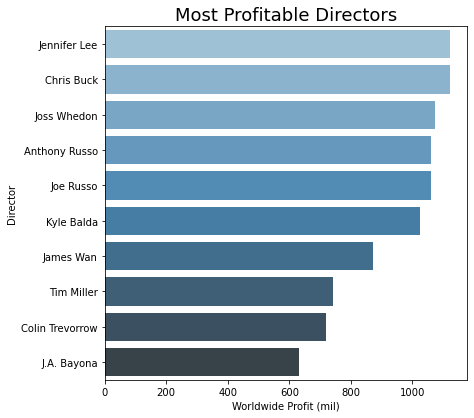

In [44]:
tmp = grouped_best_directors.sort_values('worldwide_profit_mil', ascending=False)['worldwide_profit_mil'].head(10)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.barplot(y=tmp.index, 
            x=tmp.values,
            palette="Blues_d")
ax.set_title('Most Profitable Directors')
ax.set_xlabel('Worldwide Profit (mil)')
ax.set_ylabel('Director');

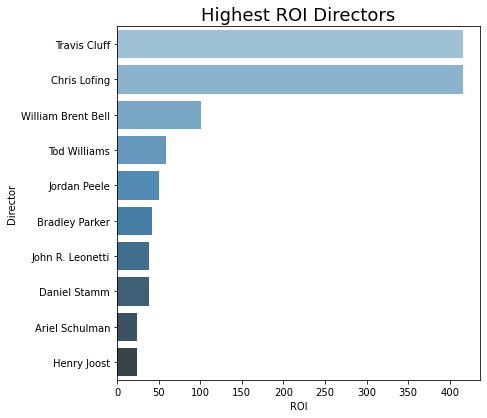

In [45]:
tmp = grouped_best_directors.sort_values('ROI', ascending=False)['ROI'].head(10)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.barplot(y=tmp.index, 
            x=tmp.values,
            palette="Blues_d")
ax.set_title('Highest ROI Directors')
ax.set_xlabel('ROI')
ax.set_ylabel('Director');

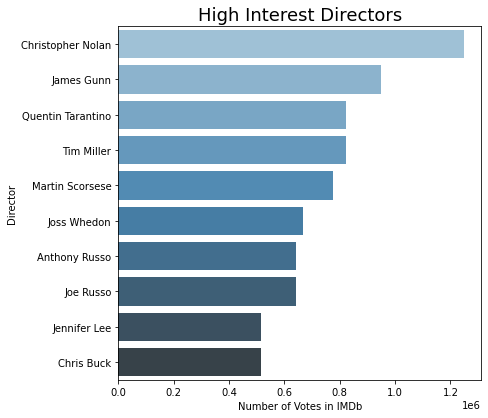

In [46]:
tmp = grouped_best_directors.sort_values('numvotes_y', ascending=False)['numvotes_y'].head(10)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
sns.barplot(y=tmp.index, 
            x=tmp.values,
            palette="Blues_d")
ax.set_title('High Interest Directors')
ax.set_xlabel('Number of Votes in IMDb')
ax.set_ylabel('Director');
#ax.ticklabel_format(scilimits=(0,1000000))
#ax.ticklabel_format(style='plain');

## Conclusions

## Next Steps